In [1]:
#this is to auto-reload modules (like utils.py)
%load_ext autoreload
%autoreload 2
    
import os
import time
import sys
from datetime import datetime
from datetime import timedelta
from dateutil import relativedelta

#import warnings


sys.path.append('../') #needed to import utils.py

import utils

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import sklearn as sk

import seaborn as sns
plt.style.use('seaborn-whitegrid')

from statsmodels.graphics.gofplots import qqplot
import scipy.stats as stats

from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test

# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

%matplotlib inline  


---
## Read data from raw `ALSFRS` CSV file

In [2]:
#set the data directory
data_dir = os.path.abspath('../01_proact_raw_data_2022')

#set the name of CSV file
data_file = f'{data_dir}/PROACT_ALSFRS.csv'

#read data and show some info
df_raw = pd.read_csv(data_file, delimiter=',', 
                     dtype={'Mode_of_Administration': 'str', 
                            'ALSFRS_Responded_By': 'str'}
                    )

utils.show_columns_stats(df_raw) 

subject_id..................... = 67612 rows (100.0%)     0 with NaN (  0.0%) Uniques=  7712 
Q1_Speech...................... = 66309 rows (98.07%)  1303 with NaN ( 1.93%) Uniques=    10 
Q2_Salivation.................. = 66307 rows (98.07%)  1305 with NaN ( 1.93%) Uniques=    10 
Q3_Swallowing.................. = 66306 rows (98.07%)  1306 with NaN ( 1.93%) Uniques=    10 
Q4_Handwriting................. = 66304 rows (98.07%)  1308 with NaN ( 1.93%) Uniques=    10 
Q5a_Cutting_without_Gastrostomy = 61262 rows (90.61%)  6350 with NaN ( 9.39%) Uniques=    10 
Q5b_Cutting_with_Gastrostomy... =  5837 rows ( 8.63%) 61775 with NaN (91.37%) Uniques=     9 
Q6_Dressing_and_Hygiene........ = 66303 rows (98.06%)  1309 with NaN ( 1.94%) Uniques=    10 
Q7_Turning_in_Bed.............. = 66299 rows (98.06%)  1313 with NaN ( 1.94%) Uniques=    10 
Q8_Walking..................... = 66303 rows (98.06%)  1309 with NaN ( 1.94%) Uniques=    10 
Q9_Climbing_Stairs............. = 66305 rows (98.07%)  1307 

## Drop rows with NaN value in the ALSFRS_Delta column

In [3]:
to_delete = df_raw.loc[(df_raw.ALSFRS_Delta.isnull())].copy()
df_raw = utils.remove_rows(df=df_raw, to_delete=to_delete)


  - Previous=67612, To delete=188, After=67424


## Remove unnecessary columns

In [4]:
cols_to_remove = ['Mode_of_Administration','ALSFRS_Responded_By']
df_raw.drop(columns=cols_to_remove, inplace=True)

utils.show_columns_stats(df_raw) 

subject_id..................... = 67424 rows (100.0%)     0 with NaN (  0.0%) Uniques=  7712 
Q1_Speech...................... = 66163 rows (98.13%)  1261 with NaN ( 1.87%) Uniques=    10 
Q2_Salivation.................. = 66161 rows (98.13%)  1263 with NaN ( 1.87%) Uniques=    10 
Q3_Swallowing.................. = 66160 rows (98.13%)  1264 with NaN ( 1.87%) Uniques=    10 
Q4_Handwriting................. = 66158 rows (98.12%)  1266 with NaN ( 1.88%) Uniques=    10 
Q5a_Cutting_without_Gastrostomy = 61147 rows (90.69%)  6277 with NaN ( 9.31%) Uniques=    10 
Q5b_Cutting_with_Gastrostomy... =  5805 rows ( 8.61%) 61619 with NaN (91.39%) Uniques=     9 
Q6_Dressing_and_Hygiene........ = 66157 rows (98.12%)  1267 with NaN ( 1.88%) Uniques=    10 
Q7_Turning_in_Bed.............. = 66154 rows (98.12%)  1270 with NaN ( 1.88%) Uniques=    10 
Q8_Walking..................... = 66157 rows (98.12%)  1267 with NaN ( 1.88%) Uniques=    10 
Q9_Climbing_Stairs............. = 66159 rows (98.12%)  1265 

----
----
----
## Create the `Q5` column to compute the correct value for Question-5,
## which is divided in `a)` and `b)` subparts

In [5]:
df = df_raw.copy()

df['Q5_Cutting'] = np.NaN
df['Patient_with_Gastrostomy'] = np.NaN

# without Gastrostomy
df.loc[(df['Q5a_Cutting_without_Gastrostomy'].isnull()==False), 'Q5_Cutting'] = df['Q5a_Cutting_without_Gastrostomy']
df.loc[(df['Q5a_Cutting_without_Gastrostomy'].isnull()==False), 'Patient_with_Gastrostomy'] = False

# with Gastrostomy
df.loc[(df['Q5b_Cutting_with_Gastrostomy'].isnull()==False), 'Q5_Cutting'] = df['Q5b_Cutting_with_Gastrostomy']
df.loc[(df['Q5b_Cutting_with_Gastrostomy'].isnull()==False), 'Patient_with_Gastrostomy'] = True

#drop columns Q5a and Q5b
df.drop(columns=['Q5a_Cutting_without_Gastrostomy', 'Q5b_Cutting_with_Gastrostomy'], axis=1, inplace=True)


df[['Q5_Cutting', 'Patient_with_Gastrostomy']]


,Q5_Cutting,Patient_with_Gastrostomy
0,2.0,False
1,3.0,False
2,4.0,False
3,1.0,False
4,2.0,False
...,...,...
67607,4.0,False
67608,4.0,False
67609,4.0,False
67610,4.0,False


In [6]:
df.loc[(df.Patient_with_Gastrostomy == True)]

,subject_id,Q1_Speech,Q2_Salivation,Q3_Swallowing,Q4_Handwriting,Q6_Dressing_and_Hygiene,Q7_Turning_in_Bed,Q8_Walking,Q9_Climbing_Stairs,Q10_Respiratory,ALSFRS_Delta,ALSFRS_Total,ALSFRS_R_Total,R_1_Dyspnea,R_2_Orthopnea,R_3_Respiratory_Insufficiency,Q5_Cutting,Patient_with_Gastrostomy
28,533,0.0,0.0,0.0,3.0,3.0,4.0,4.0,1.0,3.0,378.0,22.0,30.0,3.0,4.0,4.0,4.0,True
30,533,0.0,2.0,1.0,3.0,3.0,4.0,4.0,3.0,4.0,287.0,28.0,36.0,4.0,4.0,4.0,4.0,True
33,586,0.0,2.0,1.0,4.0,4.0,4.0,4.0,4.0,NaN,3.0,NaN,39.0,4.0,4.0,4.0,4.0,True
40,649,1.0,3.0,1.0,3.0,3.0,4.0,3.0,2.0,4.0,487.0,27.0,NaN,NaN,NaN,NaN,3.0,True
44,649,0.0,3.0,1.0,3.0,2.0,3.0,2.0,1.0,3.0,557.0,21.0,NaN,NaN,NaN,NaN,3.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67439,308058,1.0,2.0,0.0,3.0,1.0,0.0,2.0,0.0,NaN,169.0,NaN,21.0,4.0,3.0,4.0,1.0,True
67440,308058,2.0,3.0,1.0,3.0,1.0,1.0,2.0,0.0,NaN,141.0,NaN,25.0,3.0,3.0,4.0,2.0,True
67441,308058,2.0,2.0,1.0,3.0,1.0,2.0,2.0,0.0,NaN,113.0,NaN,25.0,4.0,3.0,4.0,1.0,True
67442,308058,2.0,3.0,1.0,3.0,2.0,1.0,2.0,0.0,NaN,85.0,NaN,25.0,3.0,3.0,4.0,1.0,True


----
----
----
##  Join question 10 from ALSFRS with question 10 (dyspnea) from ALSFRS-R

In [7]:
df_aux = df.copy()

to_update = df_aux.loc[
    (df_aux.Q10_Respiratory.isnull())
    &(df_aux.R_1_Dyspnea.isnull()==False)
].copy()


# set ALSFRS-R Q10_Respiratory equal to R_1_Dyspnea 
df_aux.loc[to_update.index, 'Q10_Respiratory'] = df_aux['R_1_Dyspnea']

df = df_aux.copy()

df.loc[to_update.index]

,subject_id,Q1_Speech,Q2_Salivation,Q3_Swallowing,Q4_Handwriting,Q6_Dressing_and_Hygiene,Q7_Turning_in_Bed,Q8_Walking,Q9_Climbing_Stairs,Q10_Respiratory,ALSFRS_Delta,ALSFRS_Total,ALSFRS_R_Total,R_1_Dyspnea,R_2_Orthopnea,R_3_Respiratory_Insufficiency,Q5_Cutting,Patient_with_Gastrostomy
12,348,4.0,4.0,4.0,4.0,1.0,2.0,2.0,1.0,4.0,366.0,NaN,35.0,4.0,4.0,4.0,1.0,False
13,348,4.0,4.0,4.0,4.0,2.0,3.0,2.0,1.0,4.0,99.0,NaN,38.0,4.0,4.0,4.0,2.0,False
14,348,4.0,4.0,4.0,3.0,2.0,4.0,2.0,1.0,4.0,4.0,NaN,38.0,4.0,4.0,4.0,2.0,False
15,348,4.0,4.0,4.0,4.0,2.0,3.0,2.0,1.0,4.0,201.0,NaN,38.0,4.0,4.0,4.0,2.0,False
16,348,4.0,4.0,4.0,4.0,2.0,3.0,2.0,1.0,4.0,61.0,NaN,38.0,4.0,4.0,4.0,2.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67607,587563,2.0,1.0,2.0,4.0,4.0,4.0,3.0,1.0,2.0,71.0,NaN,35.0,2.0,4.0,4.0,4.0,False
67608,587563,2.0,1.0,2.0,4.0,4.0,4.0,3.0,1.0,3.0,49.0,NaN,36.0,3.0,4.0,4.0,4.0,False
67609,587563,2.0,2.0,2.0,4.0,4.0,4.0,3.0,4.0,4.0,29.0,NaN,41.0,4.0,4.0,4.0,4.0,False
67610,587563,2.0,1.0,2.0,4.0,4.0,4.0,3.0,3.0,3.0,15.0,NaN,38.0,3.0,4.0,4.0,4.0,False


----
----
----
##  Delete rows having NaN in the Q1 to Q10 columns

In [8]:
df_aux = df.copy()

to_delete = df_aux.loc[
     (df_aux.Q1_Speech.isnull())
   | (df_aux.Q2_Salivation.isnull())
   | (df_aux.Q3_Swallowing.isnull())
   | (df_aux.Q4_Handwriting.isnull())
   | (df_aux.Q5_Cutting.isnull())
   | (df_aux.Q6_Dressing_and_Hygiene.isnull())
   | (df_aux.Q7_Turning_in_Bed.isnull())
   | (df_aux.Q8_Walking.isnull())
   | (df_aux.Q9_Climbing_Stairs.isnull())
   | (df_aux.Q10_Respiratory.isnull())
].copy()

df = utils.remove_rows(df=df, to_delete=to_delete)


  - Previous=67424, To delete=1326, After=66098


In [9]:
utils.show_columns_stats(df)


subject_id................... = 66098 rows (100.0%)     0 with NaN (  0.0%) Uniques=  7382 
Q1_Speech.................... = 66098 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q2_Salivation................ = 66098 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q3_Swallowing................ = 66098 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q4_Handwriting............... = 66098 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q6_Dressing_and_Hygiene...... = 66098 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q7_Turning_in_Bed............ = 66098 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q8_Walking................... = 66098 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q9_Climbing_Stairs........... = 66098 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q10_Respiratory.............. = 66098 rows (100.0%)     0 with NaN (  0.0%) Uniques=     7 
ALSFRS_Delta................. = 66098 rows (100.0%)     0 with NaN (  0.0%) Uniq

----
----
----
##  Calculate the Total Score for ALSFRS-R rows

In [10]:
df_aux = df.copy()

to_sum = df_aux.loc[
     (df_aux.ALSFRS_Total.isnull())
].copy()


# calculate the sum of Total_Score
df_aux.loc[to_sum.index, 'ALSFRS_Total'] = \
      df_aux.Q1_Speech  + df_aux.Q2_Salivation           + df_aux.Q3_Swallowing + df_aux.Q4_Handwriting \
    + df_aux.Q5_Cutting + df_aux.Q6_Dressing_and_Hygiene + df_aux.Q7_Turning_in_Bed \
    + df_aux.Q8_Walking + df_aux.Q9_Climbing_Stairs      + df_aux.Q10_Respiratory

df = df_aux
df

,subject_id,Q1_Speech,Q2_Salivation,Q3_Swallowing,Q4_Handwriting,Q6_Dressing_and_Hygiene,Q7_Turning_in_Bed,Q8_Walking,Q9_Climbing_Stairs,Q10_Respiratory,ALSFRS_Delta,ALSFRS_Total,ALSFRS_R_Total,R_1_Dyspnea,R_2_Orthopnea,R_3_Respiratory_Insufficiency,Q5_Cutting,Patient_with_Gastrostomy
0,329,4.0,3.0,4.0,3.0,3.0,2.0,2.0,1.0,3.0,0.0,27.0,NaN,NaN,NaN,NaN,2.0,False
1,329,4.0,3.0,4.0,3.0,3.0,3.0,2.0,1.0,4.0,42.0,30.0,NaN,NaN,NaN,NaN,3.0,False
2,329,3.0,3.0,4.0,3.0,3.0,4.0,2.0,2.0,4.0,106.0,32.0,NaN,NaN,NaN,NaN,4.0,False
3,329,4.0,2.0,4.0,3.0,3.0,3.0,2.0,1.0,3.0,247.0,26.0,NaN,NaN,NaN,NaN,1.0,False
4,329,4.0,3.0,4.0,3.0,3.0,4.0,2.0,2.0,3.0,72.0,30.0,NaN,NaN,NaN,NaN,2.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67607,587563,2.0,1.0,2.0,4.0,4.0,4.0,3.0,1.0,2.0,71.0,27.0,35.0,2.0,4.0,4.0,4.0,False
67608,587563,2.0,1.0,2.0,4.0,4.0,4.0,3.0,1.0,3.0,49.0,28.0,36.0,3.0,4.0,4.0,4.0,False
67609,587563,2.0,2.0,2.0,4.0,4.0,4.0,3.0,4.0,4.0,29.0,33.0,41.0,4.0,4.0,4.0,4.0,False
67610,587563,2.0,1.0,2.0,4.0,4.0,4.0,3.0,3.0,3.0,15.0,30.0,38.0,3.0,4.0,4.0,4.0,False


----
----
----
##  Get only necessary columns

In [11]:
df = df[[
        'subject_id',
        'Q1_Speech',
        'Q2_Salivation',
        'Q3_Swallowing',
        'Q4_Handwriting',
        'Q5_Cutting',
        'Q6_Dressing_and_Hygiene',
        'Q7_Turning_in_Bed',
        'Q8_Walking',
        'Q9_Climbing_Stairs',
        'Q10_Respiratory',
        'ALSFRS_Delta',
        'ALSFRS_Total',
        'Patient_with_Gastrostomy',
        ]].copy()

df

,subject_id,Q1_Speech,Q2_Salivation,Q3_Swallowing,Q4_Handwriting,Q5_Cutting,Q6_Dressing_and_Hygiene,Q7_Turning_in_Bed,Q8_Walking,Q9_Climbing_Stairs,Q10_Respiratory,ALSFRS_Delta,ALSFRS_Total,Patient_with_Gastrostomy
0,329,4.0,3.0,4.0,3.0,2.0,3.0,2.0,2.0,1.0,3.0,0.0,27.0,False
1,329,4.0,3.0,4.0,3.0,3.0,3.0,3.0,2.0,1.0,4.0,42.0,30.0,False
2,329,3.0,3.0,4.0,3.0,4.0,3.0,4.0,2.0,2.0,4.0,106.0,32.0,False
3,329,4.0,2.0,4.0,3.0,1.0,3.0,3.0,2.0,1.0,3.0,247.0,26.0,False
4,329,4.0,3.0,4.0,3.0,2.0,3.0,4.0,2.0,2.0,3.0,72.0,30.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67607,587563,2.0,1.0,2.0,4.0,4.0,4.0,4.0,3.0,1.0,2.0,71.0,27.0,False
67608,587563,2.0,1.0,2.0,4.0,4.0,4.0,4.0,3.0,1.0,3.0,49.0,28.0,False
67609,587563,2.0,2.0,2.0,4.0,4.0,4.0,4.0,3.0,4.0,4.0,29.0,33.0,False
67610,587563,2.0,1.0,2.0,4.0,4.0,4.0,4.0,3.0,3.0,3.0,15.0,30.0,False


In [12]:
utils.show_columns_stats(df)

subject_id.............. = 66098 rows (100.0%)     0 with NaN (  0.0%) Uniques=  7382 
Q1_Speech............... = 66098 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q2_Salivation........... = 66098 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q3_Swallowing........... = 66098 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q4_Handwriting.......... = 66098 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q5_Cutting.............. = 66098 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q6_Dressing_and_Hygiene. = 66098 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q7_Turning_in_Bed....... = 66098 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q8_Walking.............. = 66098 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q9_Climbing_Stairs...... = 66098 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q10_Respiratory......... = 66098 rows (100.0%)     0 with NaN (  0.0%) Uniques=     7 
ALSFRS_Delta............ = 66098 rows (100.

----
----
----
## Read patient static data and get only columns:
## `subject_id` and `Symptoms_Onset_Delta`

In [13]:
#set the data directory
data_dir = os.path.abspath('../03_proact_preprocessed/')

#set the name of CSV file
data_file = f'{data_dir}/_patient.csv'

#read data and show some info
df_main = pd.read_csv(data_file, delimiter=',')


cols = ['subject_id', 'Symptoms_Onset_Delta']


df_main = df_main[cols]
df_main


,subject_id,Symptoms_Onset_Delta
0,329,-1706.0
1,348,-501.0
2,533,-1023.0
3,586,-715.0
4,708,-1070.0
...,...,...
5225,22564,-426.0
5226,160135,-651.0
5227,304192,-838.0
5228,820199,-155.0


## Join the 2 datasets to calcute `ALSFRS Delta` from `Symptoms_Onset`

In [14]:
df_temp = df.copy()
df_temp = utils.join_datasets_by_key(
    df_main=df_temp, 
    df_to_join=df_main, 
    key_name='subject_id', 
    raise_error=True
)

df_temp

,subject_id,Q1_Speech,Q2_Salivation,Q3_Swallowing,Q4_Handwriting,Q5_Cutting,Q6_Dressing_and_Hygiene,Q7_Turning_in_Bed,Q8_Walking,Q9_Climbing_Stairs,Q10_Respiratory,ALSFRS_Delta,ALSFRS_Total,Patient_with_Gastrostomy,Symptoms_Onset_Delta
0,329,4.0,3.0,4.0,3.0,2.0,3.0,2.0,2.0,1.0,3.0,0.0,27.0,False,-1706.0
1,329,4.0,3.0,4.0,3.0,3.0,3.0,3.0,2.0,1.0,4.0,42.0,30.0,False,-1706.0
2,329,3.0,3.0,4.0,3.0,4.0,3.0,4.0,2.0,2.0,4.0,106.0,32.0,False,-1706.0
3,329,4.0,2.0,4.0,3.0,1.0,3.0,3.0,2.0,1.0,3.0,247.0,26.0,False,-1706.0
4,329,4.0,3.0,4.0,3.0,2.0,3.0,4.0,2.0,2.0,3.0,72.0,30.0,False,-1706.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67607,587563,2.0,1.0,2.0,4.0,4.0,4.0,4.0,3.0,1.0,2.0,71.0,27.0,False,-580.0
67608,587563,2.0,1.0,2.0,4.0,4.0,4.0,4.0,3.0,1.0,3.0,49.0,28.0,False,-580.0
67609,587563,2.0,2.0,2.0,4.0,4.0,4.0,4.0,3.0,4.0,4.0,29.0,33.0,False,-580.0
67610,587563,2.0,1.0,2.0,4.0,4.0,4.0,4.0,3.0,3.0,3.0,15.0,30.0,False,-580.0


## Create `Delta_from_Symptoms` columns (in ` days` and `months`)

In [15]:
#calculate in DAYS
df_temp['Delta_from_Symptoms_Onset_in_Days'] = df_temp.ALSFRS_Delta + np.abs(df_temp.Symptoms_Onset_Delta)

#calculate in MONTHS
df_temp['Delta_from_Symptoms_Onset'] = np.NaN
in_months = df_temp['Delta_from_Symptoms_Onset_in_Days'].apply( lambda x: utils.calculate_months_from_days(x)) 
df_temp.loc[df_temp.index,'Delta_from_Symptoms_Onset'] = in_months

df = df_temp
df

,subject_id,Q1_Speech,Q2_Salivation,Q3_Swallowing,Q4_Handwriting,Q5_Cutting,Q6_Dressing_and_Hygiene,Q7_Turning_in_Bed,Q8_Walking,Q9_Climbing_Stairs,Q10_Respiratory,ALSFRS_Delta,ALSFRS_Total,Patient_with_Gastrostomy,Symptoms_Onset_Delta,Delta_from_Symptoms_Onset_in_Days,Delta_from_Symptoms_Onset
0,329,4.0,3.0,4.0,3.0,2.0,3.0,2.0,2.0,1.0,3.0,0.0,27.0,False,-1706.0,1706.0,56.0
1,329,4.0,3.0,4.0,3.0,3.0,3.0,3.0,2.0,1.0,4.0,42.0,30.0,False,-1706.0,1748.0,57.0
2,329,3.0,3.0,4.0,3.0,4.0,3.0,4.0,2.0,2.0,4.0,106.0,32.0,False,-1706.0,1812.0,59.0
3,329,4.0,2.0,4.0,3.0,1.0,3.0,3.0,2.0,1.0,3.0,247.0,26.0,False,-1706.0,1953.0,64.0
4,329,4.0,3.0,4.0,3.0,2.0,3.0,4.0,2.0,2.0,3.0,72.0,30.0,False,-1706.0,1778.0,58.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67607,587563,2.0,1.0,2.0,4.0,4.0,4.0,4.0,3.0,1.0,2.0,71.0,27.0,False,-580.0,651.0,21.0
67608,587563,2.0,1.0,2.0,4.0,4.0,4.0,4.0,3.0,1.0,3.0,49.0,28.0,False,-580.0,629.0,20.0
67609,587563,2.0,2.0,2.0,4.0,4.0,4.0,4.0,3.0,4.0,4.0,29.0,33.0,False,-580.0,609.0,20.0
67610,587563,2.0,1.0,2.0,4.0,4.0,4.0,4.0,3.0,3.0,3.0,15.0,30.0,False,-580.0,595.0,19.0


----
----
----
## Delete some unnecessary columns and 


In [16]:
# delete unnecessary columns on ALSFRS-R data
to_delete = [
    'Symptoms_Onset_Delta', 
]
df.drop(
    columns=to_delete, 
    inplace=True
)



In [17]:
utils.show_columns_stats(df=df)

subject_id....................... = 66098 rows (100.0%)     0 with NaN (  0.0%) Uniques=  7382 
Q1_Speech........................ = 66098 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q2_Salivation.................... = 66098 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q3_Swallowing.................... = 66098 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q4_Handwriting................... = 66098 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q5_Cutting....................... = 66098 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q6_Dressing_and_Hygiene.......... = 66098 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q7_Turning_in_Bed................ = 66098 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q8_Walking....................... = 66098 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q9_Climbing_Stairs............... = 66098 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q10_Respiratory.................. = 6609

## Delete rows that have `Delta_from_Symptoms_Onset` = `NaN`

In [18]:
to_delete = df.loc[
      (df.Delta_from_Symptoms_Onset.isnull()==True)
]


df = utils.remove_rows(df=df, to_delete=to_delete)

utils.show_columns_stats(df=df)


  - Previous=66098, To delete=22644, After=43454
subject_id....................... = 43454 rows (100.0%)     0 with NaN (  0.0%) Uniques=  4903 
Q1_Speech........................ = 43454 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q2_Salivation.................... = 43454 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q3_Swallowing.................... = 43454 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q4_Handwriting................... = 43454 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q5_Cutting....................... = 43454 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q6_Dressing_and_Hygiene.......... = 43454 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q7_Turning_in_Bed................ = 43454 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q8_Walking....................... = 43454 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q9_Climbing_Stairs............... = 43454 rows (100.0%)     0 with NaN (  0.0%) Uniques

----
----
----
# Plot some distributions

Column: ALSFRS_Total  (DataType: float64)
N         = 43454 [Non-NaN: 43454]
Missingness: 0 (0.0%)
Min       = 0.00  
Max       = 40.00  
SE / Std  = 7.86  (Standard Error or Std.Dev.)
SEM       = 0.04  (Standard Error of the Mean) [Formula: Std.Dev/sqrt(N) => 7.86/sqrt(43454)] 
Mean      = 25.59 +/- 7.86 (Std.Dev.) [Precision of the Mean = 25.59 +/- 0.04 (SEM)] 
Median    = 27.00  
Mode      = 31.0
Variance  = 61.74 (Coefficient of Variation = 0.31)
Skewness  = -0.67 (Left-Skewed) (Moderately Skewed) 
Kurtosis  = -0.03 (platykurtic, rounded appearance)(PS: a high kurtosis indicates too many outliers) 
Quartiles = [Q1: 25% < 21.00]   [Q2: 50% < 27.00]   [Q3: 75% < 31.00]
 -IQR     = 10.000 (Interquartile Range: IQR = Q3-Q1)
 -Outliers Threshold (IQR * +/-1.5):  [Lower = 6.000]   [Upper = 40.000]


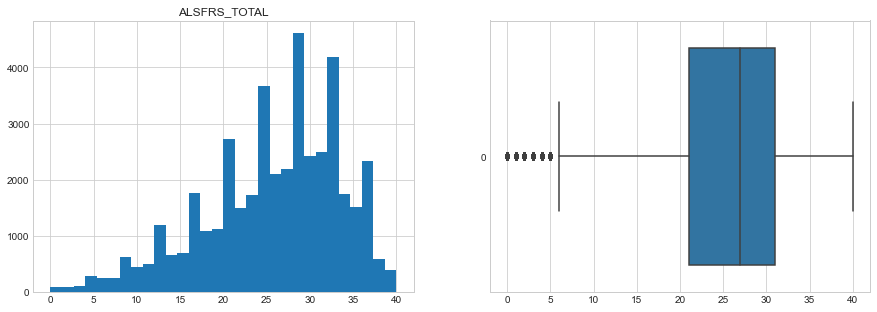

In [19]:
utils.plot_variable_distribution(df=df, column='ALSFRS_Total')


----
----
----
# Save the pre-processed data to `ALSFRS` and `ALSFRS-R` CSV files

In [20]:
dir_dest = os.path.abspath('../03_proact_preprocessed/')


# rename column
df.rename(columns={"ALSFRS_Total": "Total_Score"}, inplace=True)

# save info
csv_dest = f'{dir_dest}/_ALSFRS.csv'
utils.save_to_csv(df=df, csv_file=csv_dest)



43454 samples were saved


----
----
----
# Calculate the Slopes from Onset for each row for `ALSFRS`

### Read ALSFRS data

In [21]:
#set the data directory
dir_dest = os.path.abspath('../03_proact_preprocessed/')

#read ALSFRS data
data_file = f'{dir_dest}/_ALSFRS.csv'
df_temporal = pd.read_csv(data_file, delimiter=',')
    
utils.show_columns_stats(df_temporal)

subject_id....................... = 43454 rows (100.0%)     0 with NaN (  0.0%) Uniques=  4903 
Q1_Speech........................ = 43454 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q2_Salivation.................... = 43454 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q3_Swallowing.................... = 43454 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q4_Handwriting................... = 43454 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q5_Cutting....................... = 43454 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q6_Dressing_and_Hygiene.......... = 43454 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q7_Turning_in_Bed................ = 43454 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q8_Walking....................... = 43454 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q9_Climbing_Stairs............... = 43454 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q10_Respiratory.................. = 4345

### Sort the data by `subject_id` and `Delta_from_Symptoms_Onset_in_Days` columns

In [22]:
df_temporal.sort_values(by=['subject_id','Delta_from_Symptoms_Onset_in_Days'], inplace=True)


### Add a `Slope` column and Calculate the slope for each row.
### - Note: `MAX_SCORE` = `40`

In [23]:
max_score = 40

# calculate the slope = (Max_Score - Score)/Delta_from_Symptoms_Onset_in_months
df_temporal['Slope_from_Onset_Total_Score'] = \
        (max_score - df_temporal['Total_Score']) / df_temporal['Delta_from_Symptoms_Onset']

# round to 2 decimal places
df_temporal['Slope_from_Onset_Total_Score'] = np.round(df_temporal['Slope_from_Onset_Total_Score'], 2)


### Just cheking the slopes

In [24]:
df_temporal[['subject_id', 'Delta_from_Symptoms_Onset', 'Total_Score', 'Slope_from_Onset_Total_Score', 'Q10_Respiratory']]


,subject_id,Delta_from_Symptoms_Onset,Total_Score,Slope_from_Onset_Total_Score,Q10_Respiratory
0,329,56.0,27.0,0.23,3.0
6,329,56.0,26.5,0.24,3.0
8,329,56.0,26.0,0.25,3.0
1,329,57.0,30.0,0.18,4.0
4,329,58.0,30.0,0.17,3.0
...,...,...,...,...,...
39133,999990,11.0,22.0,1.64,4.0
39132,999990,12.0,19.0,1.75,4.0
39131,999990,13.0,19.0,1.62,4.0
39130,999990,14.0,17.0,1.64,4.0


### Solve the problem were rows have duplicated Delta_from_Symptoms_Onset

In [25]:
#sort rows by 'subject_id', 'Delta_from_Symptoms_Onset'
df_remove_duplicated = df_temporal.sort_values(['subject_id', 'Delta_from_Symptoms_Onset_in_Days'])

#get only the last row for each 'subject_id' and'Delta_from_Symptoms_Onset'
df_remove_duplicated = df_remove_duplicated.groupby(['subject_id', 'Delta_from_Symptoms_Onset']).last().reset_index()

df_temporal = df_remove_duplicated.copy()
df_temporal


,subject_id,Delta_from_Symptoms_Onset,Q1_Speech,Q2_Salivation,Q3_Swallowing,Q4_Handwriting,Q5_Cutting,Q6_Dressing_and_Hygiene,Q7_Turning_in_Bed,Q8_Walking,Q9_Climbing_Stairs,Q10_Respiratory,ALSFRS_Delta,Total_Score,Patient_with_Gastrostomy,Delta_from_Symptoms_Onset_in_Days,Slope_from_Onset_Total_Score
0,329,56.0,4.0,3.0,4.0,3.0,1.0,3.0,2.0,2.0,1.0,3.0,16.0,26.0,False,1722.0,0.25
1,329,57.0,4.0,3.0,4.0,3.0,3.0,3.0,3.0,2.0,1.0,4.0,42.0,30.0,False,1748.0,0.18
2,329,58.0,4.0,3.0,4.0,3.0,2.0,3.0,4.0,2.0,2.0,3.0,72.0,30.0,False,1778.0,0.17
3,329,59.0,3.0,3.0,4.0,3.0,4.0,3.0,4.0,2.0,2.0,4.0,106.0,32.0,False,1812.0,0.14
4,329,60.0,4.0,3.0,3.0,3.0,1.0,3.0,3.0,2.0,1.0,4.0,135.0,27.0,False,1841.0,0.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38651,999990,11.0,3.0,4.0,4.0,2.0,1.0,1.0,2.0,1.0,0.0,4.0,12.0,22.0,False,343.0,1.64
38652,999990,12.0,3.0,4.0,4.0,0.0,1.0,1.0,1.0,1.0,0.0,4.0,40.0,19.0,False,371.0,1.75
38653,999990,13.0,3.0,4.0,4.0,0.0,1.0,1.0,1.0,1.0,0.0,4.0,68.0,19.0,False,399.0,1.62
38654,999990,14.0,3.0,4.0,3.0,0.0,0.0,1.0,1.0,1.0,0.0,4.0,97.0,17.0,False,428.0,1.64


### Create Slopes for each question (1-10)

In [26]:
cols_to_create = [
    'Q1_Speech', 
    'Q2_Salivation',       
    'Q3_Swallowing', 
    'Q4_Handwriting', 
    'Q5_Cutting',
    'Q6_Dressing_and_Hygiene', 
    'Q7_Turning_in_Bed', 
    'Q8_Walking', 
    'Q9_Climbing_Stairs',
    'Q10_Respiratory', 
]
max_score = 4

df_temp = df_temporal.copy()

for col in cols_to_create:
    #define name of the column to create
    c = f'Slope_from_Onset_{col}'
    #create the column
    df_temp[c] = np.NaN
    # calculate the slope = (Max_SubScore - SubScore)/Delta_from_Symptoms_Onset
    # round to 2 decimal places
    slope = (max_score - df_temp[col]) / df_temp['Delta_from_Symptoms_Onset']
    df_temp[c] = np.round(slope, 2) 

df_temporal = df_temp.copy()
df_temporal


,subject_id,Delta_from_Symptoms_Onset,Q1_Speech,Q2_Salivation,Q3_Swallowing,Q4_Handwriting,Q5_Cutting,Q6_Dressing_and_Hygiene,Q7_Turning_in_Bed,Q8_Walking,...,Slope_from_Onset_Q1_Speech,Slope_from_Onset_Q2_Salivation,Slope_from_Onset_Q3_Swallowing,Slope_from_Onset_Q4_Handwriting,Slope_from_Onset_Q5_Cutting,Slope_from_Onset_Q6_Dressing_and_Hygiene,Slope_from_Onset_Q7_Turning_in_Bed,Slope_from_Onset_Q8_Walking,Slope_from_Onset_Q9_Climbing_Stairs,Slope_from_Onset_Q10_Respiratory
0,329,56.0,4.0,3.0,4.0,3.0,1.0,3.0,2.0,2.0,...,0.00,0.02,0.00,0.02,0.05,0.02,0.04,0.04,0.05,0.02
1,329,57.0,4.0,3.0,4.0,3.0,3.0,3.0,3.0,2.0,...,0.00,0.02,0.00,0.02,0.02,0.02,0.02,0.04,0.05,0.00
2,329,58.0,4.0,3.0,4.0,3.0,2.0,3.0,4.0,2.0,...,0.00,0.02,0.00,0.02,0.03,0.02,0.00,0.03,0.03,0.02
3,329,59.0,3.0,3.0,4.0,3.0,4.0,3.0,4.0,2.0,...,0.02,0.02,0.00,0.02,0.00,0.02,0.00,0.03,0.03,0.00
4,329,60.0,4.0,3.0,3.0,3.0,1.0,3.0,3.0,2.0,...,0.00,0.02,0.02,0.02,0.05,0.02,0.02,0.03,0.05,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38651,999990,11.0,3.0,4.0,4.0,2.0,1.0,1.0,2.0,1.0,...,0.09,0.00,0.00,0.18,0.27,0.27,0.18,0.27,0.36,0.00
38652,999990,12.0,3.0,4.0,4.0,0.0,1.0,1.0,1.0,1.0,...,0.08,0.00,0.00,0.33,0.25,0.25,0.25,0.25,0.33,0.00
38653,999990,13.0,3.0,4.0,4.0,0.0,1.0,1.0,1.0,1.0,...,0.08,0.00,0.00,0.31,0.23,0.23,0.23,0.23,0.31,0.00
38654,999990,14.0,3.0,4.0,3.0,0.0,0.0,1.0,1.0,1.0,...,0.07,0.00,0.07,0.29,0.29,0.21,0.21,0.21,0.29,0.00


---
# Save ALSFRS CSV file

In [27]:
# save info
csv_dest = f'{dir_dest}/_ALSFRS.csv'
utils.save_to_csv(df=df_temporal, csv_file=csv_dest)


38656 samples were saved


---
# Calculate the Total Score SLOPE codes
- Slow       Total:   <=0.4   Code: 0
- Average    Total: 0.5-1.3   Code: 1
- Rapid      Total:   >=1.4   Code: 2

In [29]:
df = df_temporal.copy()

to_update = df.loc[
    (df.Slope_from_Onset_Total_Score>=1.4)
].copy()
df.loc[to_update.index, 'Slope_Total_Score_Str'] = 'Rapid'
df.loc[to_update.index, 'Slope_Total_Score_Coded'] = 2


to_update = df.loc[
    (df.Slope_from_Onset_Total_Score>=0.5)
   &(df.Slope_from_Onset_Total_Score<1.4)
].copy()
df.loc[to_update.index, 'Slope_Total_Score_Str'] = 'Average'
df.loc[to_update.index, 'Slope_Total_Score_Coded'] = 1


to_update = df.loc[
    (df.Slope_from_Onset_Total_Score<0.5)
].copy()
df.loc[to_update.index, 'Slope_Total_Score_Str'] = 'Slow'
df.loc[to_update.index, 'Slope_Total_Score_Coded'] = 0

df

,subject_id,Delta_from_Symptoms_Onset,Q1_Speech,Q2_Salivation,Q3_Swallowing,Q4_Handwriting,Q5_Cutting,Q6_Dressing_and_Hygiene,Q7_Turning_in_Bed,Q8_Walking,...,Slope_from_Onset_Q3_Swallowing,Slope_from_Onset_Q4_Handwriting,Slope_from_Onset_Q5_Cutting,Slope_from_Onset_Q6_Dressing_and_Hygiene,Slope_from_Onset_Q7_Turning_in_Bed,Slope_from_Onset_Q8_Walking,Slope_from_Onset_Q9_Climbing_Stairs,Slope_from_Onset_Q10_Respiratory,Slope_Total_Score_Str,Slope_Total_Score_Coded
0,329,56.0,4.0,3.0,4.0,3.0,1.0,3.0,2.0,2.0,...,0.00,0.02,0.05,0.02,0.04,0.04,0.05,0.02,Slow,0.0
1,329,57.0,4.0,3.0,4.0,3.0,3.0,3.0,3.0,2.0,...,0.00,0.02,0.02,0.02,0.02,0.04,0.05,0.00,Slow,0.0
2,329,58.0,4.0,3.0,4.0,3.0,2.0,3.0,4.0,2.0,...,0.00,0.02,0.03,0.02,0.00,0.03,0.03,0.02,Slow,0.0
3,329,59.0,3.0,3.0,4.0,3.0,4.0,3.0,4.0,2.0,...,0.00,0.02,0.00,0.02,0.00,0.03,0.03,0.00,Slow,0.0
4,329,60.0,4.0,3.0,3.0,3.0,1.0,3.0,3.0,2.0,...,0.02,0.02,0.05,0.02,0.02,0.03,0.05,0.00,Slow,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38651,999990,11.0,3.0,4.0,4.0,2.0,1.0,1.0,2.0,1.0,...,0.00,0.18,0.27,0.27,0.18,0.27,0.36,0.00,Rapid,2.0
38652,999990,12.0,3.0,4.0,4.0,0.0,1.0,1.0,1.0,1.0,...,0.00,0.33,0.25,0.25,0.25,0.25,0.33,0.00,Rapid,2.0
38653,999990,13.0,3.0,4.0,4.0,0.0,1.0,1.0,1.0,1.0,...,0.00,0.31,0.23,0.23,0.23,0.23,0.31,0.00,Rapid,2.0
38654,999990,14.0,3.0,4.0,3.0,0.0,0.0,1.0,1.0,1.0,...,0.07,0.29,0.29,0.21,0.21,0.21,0.29,0.00,Rapid,2.0


---
# Calculate the Subscores SLOPE codes
    - Slow       Subscore:    <=0.04    Code: 0
	- Average    Subscore: 0.05-0.13    Code: 1
	- Rapid      Subscore:    >=0.14    Code: 2


In [30]:
cols_slope = [
    'Slope_from_Onset_Q1_Speech',
    'Slope_from_Onset_Q2_Salivation',
    'Slope_from_Onset_Q3_Swallowing',
    'Slope_from_Onset_Q4_Handwriting',
    'Slope_from_Onset_Q5_Cutting',
    'Slope_from_Onset_Q6_Dressing_and_Hygiene',
    'Slope_from_Onset_Q7_Turning_in_Bed',
    'Slope_from_Onset_Q8_Walking',
    'Slope_from_Onset_Q9_Climbing_Stairs',
    'Slope_from_Onset_Q10_Respiratory',
]

for col_slope in cols_slope:
    to_update = df.loc[
        (df[col_slope]>=0.14)
    ].copy()
    df.loc[to_update.index, f'{col_slope}_Str'] = 'Rapid'
    df.loc[to_update.index, f'{col_slope}_Coded'] = 2


    to_update = df.loc[
        (df[col_slope]>=0.05)
       &(df[col_slope]<0.14)
    ].copy()
    df.loc[to_update.index, f'{col_slope}_Str'] = 'Average'
    df.loc[to_update.index, f'{col_slope}_Coded'] = 1


    to_update = df.loc[
        (df[col_slope]<0.05)
    ].copy()
    df.loc[to_update.index, f'{col_slope}_Str'] = 'Slow'
    df.loc[to_update.index, f'{col_slope}_Coded'] = 0
    
df    

,subject_id,Delta_from_Symptoms_Onset,Q1_Speech,Q2_Salivation,Q3_Swallowing,Q4_Handwriting,Q5_Cutting,Q6_Dressing_and_Hygiene,Q7_Turning_in_Bed,Q8_Walking,...,Slope_from_Onset_Q6_Dressing_and_Hygiene_Str,Slope_from_Onset_Q6_Dressing_and_Hygiene_Coded,Slope_from_Onset_Q7_Turning_in_Bed_Str,Slope_from_Onset_Q7_Turning_in_Bed_Coded,Slope_from_Onset_Q8_Walking_Str,Slope_from_Onset_Q8_Walking_Coded,Slope_from_Onset_Q9_Climbing_Stairs_Str,Slope_from_Onset_Q9_Climbing_Stairs_Coded,Slope_from_Onset_Q10_Respiratory_Str,Slope_from_Onset_Q10_Respiratory_Coded
0,329,56.0,4.0,3.0,4.0,3.0,1.0,3.0,2.0,2.0,...,Slow,0.0,Slow,0.0,Slow,0.0,Average,1.0,Slow,0.0
1,329,57.0,4.0,3.0,4.0,3.0,3.0,3.0,3.0,2.0,...,Slow,0.0,Slow,0.0,Slow,0.0,Average,1.0,Slow,0.0
2,329,58.0,4.0,3.0,4.0,3.0,2.0,3.0,4.0,2.0,...,Slow,0.0,Slow,0.0,Slow,0.0,Slow,0.0,Slow,0.0
3,329,59.0,3.0,3.0,4.0,3.0,4.0,3.0,4.0,2.0,...,Slow,0.0,Slow,0.0,Slow,0.0,Slow,0.0,Slow,0.0
4,329,60.0,4.0,3.0,3.0,3.0,1.0,3.0,3.0,2.0,...,Slow,0.0,Slow,0.0,Slow,0.0,Average,1.0,Slow,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38651,999990,11.0,3.0,4.0,4.0,2.0,1.0,1.0,2.0,1.0,...,Rapid,2.0,Rapid,2.0,Rapid,2.0,Rapid,2.0,Slow,0.0
38652,999990,12.0,3.0,4.0,4.0,0.0,1.0,1.0,1.0,1.0,...,Rapid,2.0,Rapid,2.0,Rapid,2.0,Rapid,2.0,Slow,0.0
38653,999990,13.0,3.0,4.0,4.0,0.0,1.0,1.0,1.0,1.0,...,Rapid,2.0,Rapid,2.0,Rapid,2.0,Rapid,2.0,Slow,0.0
38654,999990,14.0,3.0,4.0,3.0,0.0,0.0,1.0,1.0,1.0,...,Rapid,2.0,Rapid,2.0,Rapid,2.0,Rapid,2.0,Slow,0.0


---
---
---
## Create _Regions-Involved_ Groups and set their values
### Their values can be TRUE or FALSE, being TRUE will indicate the lost of at least 1 point in the maximum region score:
```
 - Bulbar     = questions 1–3     Max. region score = 12
 - Upper Limb = questions 4–5     Max. region score = 8 
 - Lower Limb = questions 8–9     Max. region score = 8 
 - Respiratory: 
   - ALSFRS-R =  questions 10-12  Max. region score = 12
   - ALSFRS   =  question  10     Max. region score = 4
```   

Reference: Manera et. al. (2019) - Regional spreading.....

In [31]:
df_groups = df.copy()

# ==================================================
# create Region_Involved_Bulbar column
# ==================================================
df_groups['Region_Involved_Bulbar'] = \
    ((df_groups['Q1_Speech'] + df_groups['Q2_Salivation'] + df_groups['Q3_Swallowing']) < 12) * 1.0

# display(df_groups[['Q1_Speech', 'Q2_Salivation', 'Q3_Swallowing', 'Region_Involved_Bulbar']])
# utils.plot_variable_distribution(series=df_groups.Region_Involved_Bulbar)


# ==================================================
# create Region_Involved_Upper_Limb column
# ==================================================
df_groups['Region_Involved_Upper_Limb'] = \
    ((df_groups['Q4_Handwriting'] + df_groups['Q5_Cutting'] ) < 8) * 1.0

# display(df_groups[['Q4_Handwriting', 'Q5_Cutting', 'Region_Involved_Upper_Limb']])
# utils.plot_variable_distribution(series=df_groups.Region_Involved_Upper_Limb)


# ==================================================
# create Region_Involved_Lower_Limb column
# ==================================================
df_groups['Region_Involved_Lower_Limb'] = \
    ((df_groups['Q8_Walking'] + df_groups['Q9_Climbing_Stairs'] ) < 8) * 1.0

# display(df_groups[['Q8_Walking', 'Q9_Climbing_Stairs', 'Region_Involved_Lower_Limb']])
# utils.plot_variable_distribution(series=df_groups.Region_Involved_Lower_Limb)


# ==================================================
# create Region_Involved_Respiratory column
# ==================================================
df_groups['Region_Involved_Respiratory'] = ((df_groups['Q10_Respiratory']) < 4) * 1.0



df_temporal = df_groups

df_temporal


utils.show_columns_stats(df_temporal)

subject_id.................................... = 38656 rows (100.0%)     0 with NaN (  0.0%) Uniques=  4903 
Delta_from_Symptoms_Onset..................... = 38656 rows (100.0%)     0 with NaN (  0.0%) Uniques=   167 
Q1_Speech..................................... = 38656 rows (100.0%)     0 with NaN (  0.0%) Uniques=     8 
Q2_Salivation................................. = 38656 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q3_Swallowing................................. = 38656 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q4_Handwriting................................ = 38656 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q5_Cutting.................................... = 38656 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q6_Dressing_and_Hygiene....................... = 38656 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q7_Turning_in_Bed............................. = 38656 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q8_Walking.........

---
---
---
## Create _Qty-Regions-Involved_ summing all 4 groups (Bulbar, Upper Limb, Lower Limb, Respiratory)
Reference: Manera et. al. (2019) - Regional spreading.....

Column: Qty_Regions_Involved  (DataType: object)
N         = 38656 [Non-NaN: 38656]
Missingness: 0 (0.0%)

Summary Table:
     count percentage
3.0  12741     32.96%
4.0  11587     29.97%
2.0   9370     24.24%
1.0   4794     12.40%
0.0    164      0.42%


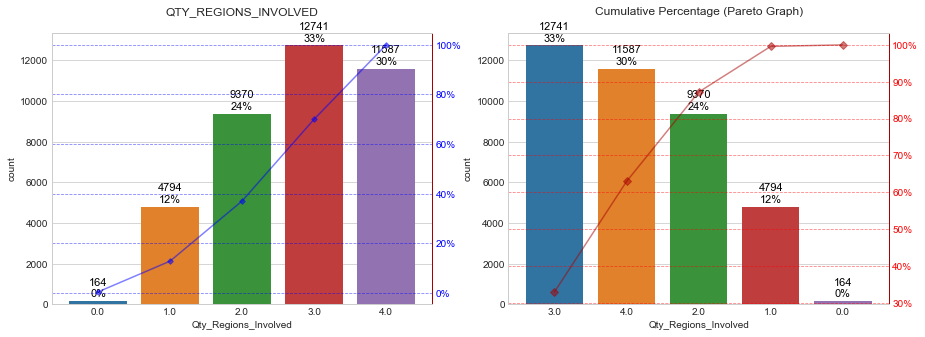

Column: Region_Involved_Bulbar  (DataType: object)
N         = 38656 [Non-NaN: 38656]
Missingness: 0 (0.0%)

Summary Table:
     count percentage
1.0  25708     66.50%
0.0  12948     33.50%


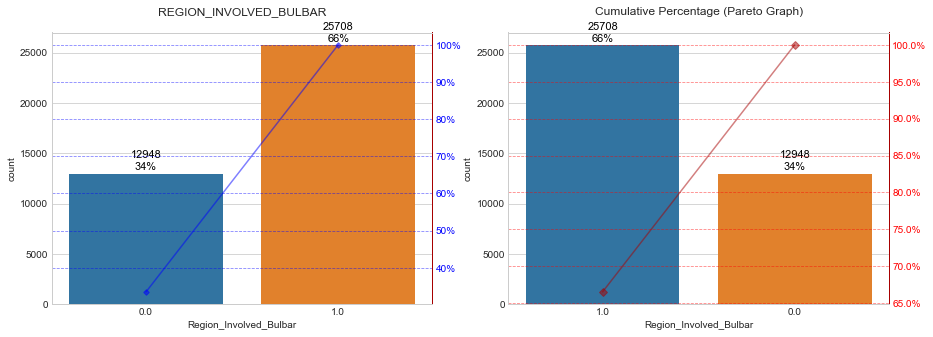

Column: Region_Involved_Upper_Limb  (DataType: object)
N         = 38656 [Non-NaN: 38656]
Missingness: 0 (0.0%)

Summary Table:
     count percentage
1.0  32652     84.47%
0.0   6004     15.53%


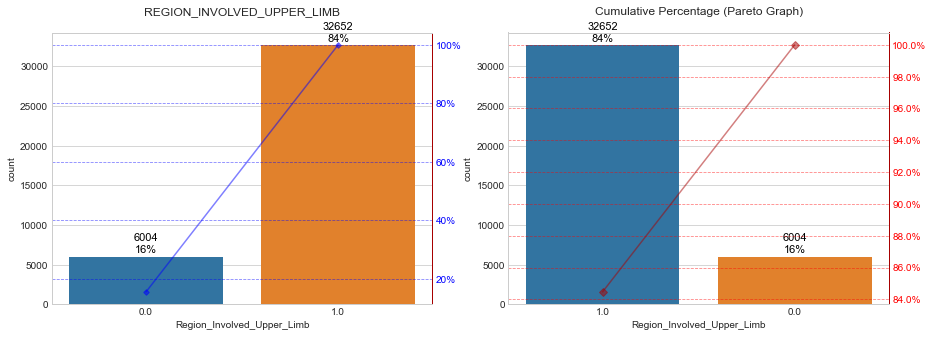

Column: Region_Involved_Lower_Limb  (DataType: object)
N         = 38656 [Non-NaN: 38656]
Missingness: 0 (0.0%)

Summary Table:
     count percentage
1.0  33822     87.49%
0.0   4834     12.51%


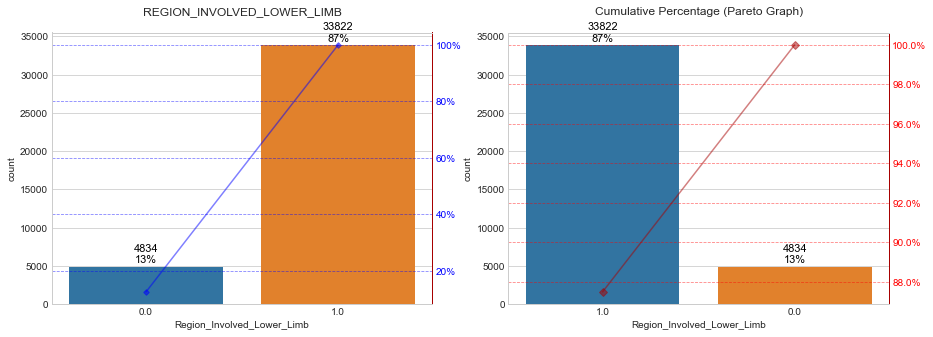

Column: Region_Involved_Respiratory  (DataType: object)
N         = 38656 [Non-NaN: 38656]
Missingness: 0 (0.0%)

Summary Table:
     count percentage
0.0  22733     58.81%
1.0  15923     41.19%


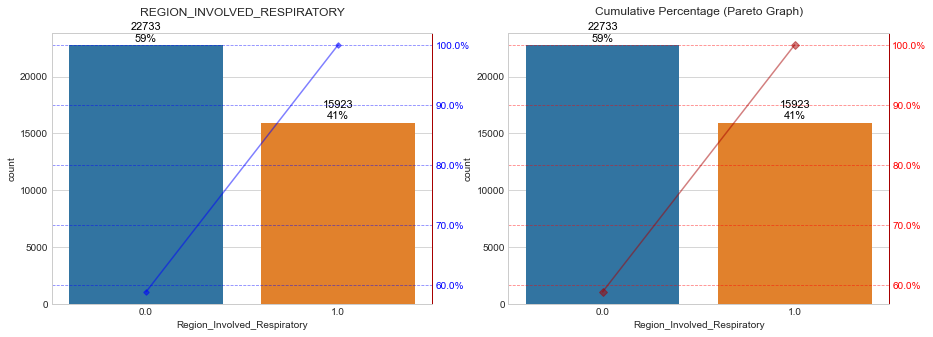

In [32]:
# create column
df_temporal['Qty_Regions_Involved'] = np.NaN

# sum 4 groups
df_temporal['Qty_Regions_Involved'] = \
      df_temporal['Region_Involved_Bulbar'] + df_temporal['Region_Involved_Upper_Limb']  \
    + df_temporal['Region_Involved_Lower_Limb'] + df_temporal['Region_Involved_Respiratory'] 
  

utils.plot_variable_distribution(series=df_temporal['Qty_Regions_Involved'].astype(str))

utils.plot_variable_distribution(series=df_temporal.Region_Involved_Bulbar.astype(str))
utils.plot_variable_distribution(series=df_temporal.Region_Involved_Upper_Limb.astype(str))
utils.plot_variable_distribution(series=df_temporal.Region_Involved_Lower_Limb.astype(str))
utils.plot_variable_distribution(series=df_temporal.Region_Involved_Respiratory.astype(str))



In [33]:
utils.show_columns_stats(df_temporal)

subject_id.................................... = 38656 rows (100.0%)     0 with NaN (  0.0%) Uniques=  4903 
Delta_from_Symptoms_Onset..................... = 38656 rows (100.0%)     0 with NaN (  0.0%) Uniques=   167 
Q1_Speech..................................... = 38656 rows (100.0%)     0 with NaN (  0.0%) Uniques=     8 
Q2_Salivation................................. = 38656 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q3_Swallowing................................. = 38656 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q4_Handwriting................................ = 38656 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q5_Cutting.................................... = 38656 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q6_Dressing_and_Hygiene....................... = 38656 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q7_Turning_in_Bed............................. = 38656 rows (100.0%)     0 with NaN (  0.0%) Uniques=     9 
Q8_Walking.........

---
# Save ALSFRS CSV file

In [34]:
# save info
csv_dest = f'{dir_dest}/_ALSFRS.csv'
utils.save_to_csv(df=df_temporal, csv_file=csv_dest)


38656 samples were saved


---
---
# Generate Time-Series from Symptoms-Onset for each patient

In [35]:
# Get values by month up to 72 months (i.e., 6 years)
n_years = 10
threshold = 12 * n_years # "n" years
months = np.linspace(0, threshold, threshold+1, dtype=float) #[1.0, 2.0, 3.0,..., 72.0]


baselines = [
    'Symptoms_Onset'
]

columns_questions_ALSFRS = [
    'Q1_Speech',
    'Q2_Salivation',
    'Q3_Swallowing',
    'Q4_Handwriting',
    'Q5_Cutting',
    'Q6_Dressing_and_Hygiene',
    'Q7_Turning_in_Bed',
    'Q8_Walking',
    'Q9_Climbing_Stairs',
    'Q10_Respiratory',
]

columns_not_to_interpolate = [
    'Q1_Speech',
    'Q2_Salivation',
    'Q3_Swallowing',
    'Q4_Handwriting',
    'Q5_Cutting',
    'Q6_Dressing_and_Hygiene',
    'Q7_Turning_in_Bed',
    'Q8_Walking',
    'Q9_Climbing_Stairs',
    'Q10_Respiratory',
    'Total_Score',
    #
    'Region_Involved_Bulbar',
    'Region_Involved_Upper_Limb',
    'Region_Involved_Lower_Limb',
    'Region_Involved_Respiratory',
    'Qty_Regions_Involved',
    # boolean columns
    'Patient_with_Gastrostomy',

]
columns_to_interpolate = [
    #
    'Slope_from_Onset_Total_Score',
    'Slope_from_Onset_Q1_Speech',
    'Slope_from_Onset_Q2_Salivation',
    'Slope_from_Onset_Q3_Swallowing',
    'Slope_from_Onset_Q4_Handwriting',
    'Slope_from_Onset_Q5_Cutting',
    'Slope_from_Onset_Q6_Dressing_and_Hygiene',
    'Slope_from_Onset_Q7_Turning_in_Bed',
    'Slope_from_Onset_Q8_Walking',
    'Slope_from_Onset_Q9_Climbing_Stairs',
    'Slope_from_Onset_Q10_Respiratory',
]

columns = columns_not_to_interpolate + columns_to_interpolate

dir_dest = os.path.abspath('../03_proact_preprocessed/')


for baseline in baselines:
    
    for column in columns:

        col_baseline = f'Delta_from_{baseline}'

        # copy data ordering by col_baseline
        df_copy = df_temporal.sort_values(by=['subject_id', col_baseline]).copy()


        # convert boolean values to 0/1 for Boolean cloumns
        if (column == 'Patient_with_Gastrostomy') | (column.startswith('Region_Involved_')):
            df_copy[column].replace({True: 1, False: 0}, inplace=True)
            
        # drop rows with NaN in "col_baseline" and "column"
        df_copy.dropna(
            subset=[
                col_baseline, 
                column,
            ], 
            inplace=True
        )

        # filter rows by threshold
        df_pivot = df_copy.copy()

        # get only the names of the Values columns 
        cols_to_pivot = df_pivot.columns[2:]

        # create pivot by column Result
        df_aux = df_pivot.pivot_table(
            index='subject_id', 
            columns=col_baseline, 
            values=column,
            aggfunc=np.max, # get max value in that month (can exist 2+ measurements for a same month)
        )

        # reset index
        df_aux.reset_index(inplace=True)

        # get the month-columns existing in the pivot-table
        cols_months = df_aux.columns[1:]

        # check if all months columns were created [1-72]
        for month in months:
            # if month not present in the columns
            if month not in cols_months:
                # Creating column for this month and set its values to NaN
                # PS: "int(month)" is used to keep columns ordered by month number
                df_aux.insert(int(month), month, np.NaN)

        # code to ensure the order of the columns
        cols_months_ordered = list(sorted(months))
        cols_months_ordered.insert(0, 'subject_id')
        df_aux = df_aux[cols_months_ordered]
        
        
        round_decimal_places = 2
        
        # if column is a slope Total-Score from onset, set month-0 = 0.0 (none decline or increase)
        if (column == 'Slope_from_Onset_Total_Score') | ('Slope_from_Onset_Q' in column):
            df_aux[0.0] = 0.0
        # if column is Total_Score_Joined from onset, set month-0 = 40 (Max score for ALSFRS)
        elif ('Total_Score' in column):
            df_aux[0.0] = 40.0
            round_decimal_places = 0
        # if column is a ALSFRS question, set month-0 = 4 (Max score for each ALSFRS question)
        elif (column in columns_questions_ALSFRS):
            df_aux[0.0] = 4.0
            round_decimal_places = 0
        # if column is to do not interpolate, set round_decimal_places = 0
        elif (column in columns_not_to_interpolate):
            round_decimal_places = 0

        
        # save data for each Value column
        col_name = column.replace('_from_Onset', '')
        print(f'{col_baseline}  - {column}')
        csv_file = f'{dir_dest}/TimeSeries/ALSFRS/without_MI/ALSFRS_TimeSeries_{col_name}.csv'
        utils.save_to_csv(df=df_aux, csv_file=csv_file)


        # read file saved to fill NaN values using interpolation
        df_fill_nan_using_interpolation = pd.read_csv(csv_file, delimiter=',')
        
#         # delete the auxiliary file
#         os.remove(csv_file)
        
        # get columns ignoring 'subject_id'
        cols_months = df_fill_nan_using_interpolation.columns[1:]


        # perform Missing Imputation using interpolation
        df_aux = df_fill_nan_using_interpolation[cols_months].interpolate(
            method='linear', 
            limit_direction='both',
            limit=1000, 
            axis=1, 
            inplace=False,
        ).copy()
        
        # round Values using "round_decimal_places" variable
        df_aux[cols_months] = np.round(df_aux[cols_months], round_decimal_places)
        
        # get subject_id column
        df_fill_nan_using_interpolation[cols_months] = df_aux[cols_months]

        # drop rows with NaN values (where there is no Value registered)
        df_fill_nan_using_interpolation.dropna(inplace=True)

        # save data again for each Value column with interpolation
        print(f'{col_baseline} with_Missing_Imputation')
        csv_file = f'{dir_dest}/TimeSeries/ALSFRS/ALSFRS_TimeSeries_{col_name}_with_MI.csv'
        utils.save_to_csv(df=df_fill_nan_using_interpolation, csv_file=csv_file)

        # just for further tests
        df_aux = df_fill_nan_using_interpolation.copy()

        print()



Delta_from_Symptoms_Onset  - Q1_Speech
4903 samples were saved
Delta_from_Symptoms_Onset with_Missing_Imputation
4903 samples were saved

Delta_from_Symptoms_Onset  - Q2_Salivation
4903 samples were saved
Delta_from_Symptoms_Onset with_Missing_Imputation
4903 samples were saved

Delta_from_Symptoms_Onset  - Q3_Swallowing
4903 samples were saved
Delta_from_Symptoms_Onset with_Missing_Imputation
4903 samples were saved

Delta_from_Symptoms_Onset  - Q4_Handwriting
4903 samples were saved
Delta_from_Symptoms_Onset with_Missing_Imputation
4903 samples were saved

Delta_from_Symptoms_Onset  - Q5_Cutting
4903 samples were saved
Delta_from_Symptoms_Onset with_Missing_Imputation
4903 samples were saved

Delta_from_Symptoms_Onset  - Q6_Dressing_and_Hygiene
4903 samples were saved
Delta_from_Symptoms_Onset with_Missing_Imputation
4903 samples were saved

Delta_from_Symptoms_Onset  - Q7_Turning_in_Bed
4903 samples were saved
Delta_from_Symptoms_Onset with_Missing_Imputation
4903 samples were saved

# Generate Coded for Time-series slopes

In [36]:
def process(df, code=True, multiplier=1):
    df_return = df.copy()
    for col_slope in df.columns:
        if col_slope != 'subject_id':
            
            if code==False:
                df_return[col_slope] = df_return[col_slope].astype(str)
                df_return[col_slope].replace('nan', np.nan, inplace=True)
            
            to_update = df.loc[
                (df[col_slope].isnull()==False)
               &(df[col_slope]>=(0.14 * multiplier) )
            ].copy()
            if code:
                df_return.loc[to_update.index, col_slope] = 2
            else:
                df_return.loc[to_update.index, col_slope] = 'Rapid'


            to_update = df.loc[
                (df[col_slope].isnull()==False)
               &(df[col_slope]>=(0.05 * multiplier) )
               &(df[col_slope]<(0.14 * multiplier) )
            ].copy()
            if code:
                df_return.loc[to_update.index, col_slope] = 1
            else:
                df_return.loc[to_update.index, col_slope] = 'Average'


            to_update = df.loc[
                (df[col_slope].isnull()==False)
               &(df[col_slope]<(0.05 * multiplier) )
            ].copy()
            if code:
                df_return.loc[to_update.index, col_slope] = 0
            else:
                df_return.loc[to_update.index, col_slope] = 'Slow'

    return df_return

In [37]:

csv_ts_files = [
    'Slope_Total_Score',
    'Slope_Q1_Speech',
    'Slope_Q2_Salivation',
    'Slope_Q3_Swallowing',
    'Slope_Q4_Handwriting',
    'Slope_Q5_Cutting',
    'Slope_Q6_Dressing_and_Hygiene',
    'Slope_Q7_Turning_in_Bed',
    'Slope_Q8_Walking',
    'Slope_Q9_Climbing_Stairs',
    'Slope_Q10_Respiratory',
]

dir_dest = os.path.abspath('../03_proact_preprocessed/')
    
for csv_ts_file in csv_ts_files:

    if csv_ts_file == 'Slope_Total_Score':
        multiplier = 10
    else:    
        multiplier = 1
    
    print()
    print(f'{csv_ts_file}')
    
    csv = f'{dir_dest}/TimeSeries/ALSFRS/ALSFRS_TimeSeries_{csv_ts_file}_with_MI.csv'
    df = pd.read_csv(filepath_or_buffer=csv, delimiter=',')
    #code
    df = process(df, multiplier=multiplier, code=True)    
    csv_to_save = f'{dir_dest}/TimeSeries/ALSFRS/ALSFRS_TimeSeries_{csv_ts_file}_Coded_with_MI.csv'
    utils.save_to_csv(df=df, csv_file=csv_to_save)
#     #string
#     df = process(df, multiplier=multiplier, code=False)    
#     csv_to_save = f'{dir_dest}/TimeSeries/ALSFRS/ALSFRS_TimeSeries_{csv_ts_file}_Str_with_MI.csv'
#     utils.save_to_csv(df=df, csv_file=csv_to_save)
    


Slope_Total_Score
4903 samples were saved

Slope_Q1_Speech
4903 samples were saved

Slope_Q2_Salivation
4903 samples were saved

Slope_Q3_Swallowing
4903 samples were saved

Slope_Q4_Handwriting
4903 samples were saved

Slope_Q5_Cutting
4903 samples were saved

Slope_Q6_Dressing_and_Hygiene
4903 samples were saved

Slope_Q7_Turning_in_Bed
4903 samples were saved

Slope_Q8_Walking
4903 samples were saved

Slope_Q9_Climbing_Stairs
4903 samples were saved

Slope_Q10_Respiratory
4903 samples were saved
